# Capstone Proposal
[Link to Capstone Proposal](https://docs.google.com/document/d/1mas-YDI0C1bP-O6wKjwplSKIP6eb1z0eGJJ3U1x1kGo/edit?usp=sharing)

# Imports

In [136]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import re

import matplotlib.pyplot as plt

from wordcloud import WordCloud
from PIL import Image
from os import path

# Princeton Corpus of Political Emails 
[Documentation](https://electionemails2020.org/assets/corpus_documentation_v1.0.pdf)

In [4]:
corpus = pd.read_csv('corpus_v1.0/corpus_v1.0.csv', low_memory=False)

In [5]:
corpus.head()

,from_name,from_address,subject,body_text,name,office_sought,party_affiliation,office_level,district_type,final_website,crawl_date,source,state,type,subtype,date,hour,day,uid_email,uid_inbox,incumbent
0,Kathleen Williams,info@kathleenformontana.com,Welcome to the team!,Thanks for joining the team! My name is Kathle...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2019-12-05,19,Thu,7182e4e604717330ecaf2699be61b200,08f13962c5b2090e32c902552a4ff634,No
1,Goal Update -- via Team Kathleen,info@kathleenformontana.com,Quickly closing in,We’re just 5 days away from our June 30th FEC ...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-06-25,14,Thu,00768081c0a2487180314475ed1121d1,08f13962c5b2090e32c902552a4ff634,No
2,Kathleen Williams,info@kathleenformontana.com,Welcome to the team!,Thanks for joining the team! My name is Kathle...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2019-12-03,19,Tue,54f56022dcd037ccb583f65a5668a073,08f13962c5b2090e32c902552a4ff634,No
3,Kathleen Williams,teamwilliams@kathleenformontana.com,Remembering Dr. King,Today we remember and honor the legacy of Dr. ...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-01-20,12,Mon,ff3fc8ba9b209b771a73ef831a4117b5,08f13962c5b2090e32c902552a4ff634,No
4,Jeff Allen,teamwilliams@kathleenformontana.com,We need to close the gap fast,"Here’s the truth,summer is the most difficult ...",Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-07-27,17,Mon,36e237928f238bf5fab8d5a5462d9a04,08f13962c5b2090e32c902552a4ff634,No


In [6]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317366 entries, 0 to 317365
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   from_name          317364 non-null  object
 1   from_address       317359 non-null  object
 2   subject            317351 non-null  object
 3   body_text          316790 non-null  object
 4   name               317366 non-null  object
 5   office_sought      198972 non-null  object
 6   party_affiliation  220390 non-null  object
 7   office_level       198972 non-null  object
 8   district_type      198972 non-null  object
 9   final_website      317366 non-null  object
 10  crawl_date         317366 non-null  object
 11  source             317366 non-null  object
 12  state              11175 non-null   object
 13  type               118394 non-null  object
 14  subtype            67441 non-null   object
 15  date               317366 non-null  object
 16  hour               3

# Target investigation: 
* The target variable for this dataset is `party_affiliation`
* 96,976 emails that are not labled with a polticial `party_affiliation`
* If an email originates from a organization the organization it was not assigned a `party_affiliation` and I will need to establish the organization's party affilation

In [7]:
#create target
corpus['target'] = corpus['party_affiliation']

In [8]:
#number of target nulls
corpus['target'].isna().sum()

96976

In [9]:
corpus['target'].value_counts()

Democratic Party                              175234
Republican Party                               42208
Nonpartisan                                      653
Independent                                      556
Libertarian Party                                488
Working Families Party                           465
Green Party                                      381
Serve America Movement Party                     203
Maine Green Independent Party                     87
Independence Party                                48
United Utah Party                                 26
Constitution Party                                23
None                                               4
SAM Party of New York                              4
Alliance Party of South Carolina                   3
Democratic-Farmer-Labor Party of Minnesota         2
Unaffiliated                                       2
Unity Party                                        1
Reform Party                                  

In [10]:
#Sources: “ballotpedia-campaign” if the email was from a candidate running for office and “orgs” if the email was from an organization.
corpus['source'].value_counts()

ballotpedia-campaign    198972
orgs                    118394
Name: source, dtype: int64

118,394 emails in the corpus originate from organizations

# OpenSecrets Data Imports
Data from 2020 campaign cycle: [Data Dictionary](https://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20Candidates%20Data.htm), 
[Bulk Data Documentation](https://www.opensecrets.org/open-data/bulk-data-documentation)

This data was downloaded from OpenSecrets.org which originates from the FEC, the regulating body for campaigns in the United States. 
 
Data from OpenSecrets is imported in five tables and covers: 
1. information about the candidates and the committees (such as organizations and PACs). This information is found in `cands20` and `cmtes20`. They are high-level information including names, unique IDs, and when possible party affiliation. 
2. information about contributions. Contributions are in the form of organization to candidate and organization to organization. 
3. organization [outside spending by viewpoint](https://www.opensecrets.org/outsidespending/summ.php?cycle=2020&chrt=V&disp=O&type=A) establishes a liberal, conservative, or other viewpoint.

In [11]:
#Candidates - cands20 import (Candidate Information)
cands20 = pd.read_csv('CampaignFin20/cands20.txt', delimiter=",", quotechar="|", header=None)
cands20.columns = ['Cycle', 'FECCandID', 'CID', 'FirstLastP', 'Party', 'DistIDRunFor',
    'DistIDCurr', 'CurrCand', 'CycleCand','CRPICO', 'RecipCode', 'NoPacs']

#FEC Committees - cmtes20 import (PACs and Candidate and Party Committees Information) 
cmtes20 = pd.read_csv('CampaignFin20/cmtes20.txt', delimiter=",", quotechar="|", header=None)
cmtes20.columns = ['Cycle', 'CmteID', 'PACShort', 'Affiliate', 'Ultorg', 'RecipID', 
    'RecipCode', 'FECCandID', 'Party', 'PrimCode', 'Source', 'Sensitive', 'Foreign', 'Active']

#PAC - pacs20 import (Contributions from PACs to Canidates)
pacs = pd.read_csv('CampaignFin20/pacs20.txt', delimiter=",", quotechar="|", header=None)
pacs.columns = ['Cycle', 'FECRecNo', 'PACID', 'CID', 'Amount', 'Date', 'RealCode', 'Type', 'DI', 'FECCandID']

#Other - pac_other20 import (Contribution from PACs to other PACs or other organizations)
pac_other = pd.read_csv('CampaignFin20/pac_other20.txt', delimiter=",", quotechar="|", header=None, low_memory=False)
pac_other.columns= ['Cycle', 'FECRecNo', 'Filerid', 'DonorCmte', 'ContribLendTrans', 'City', 'State', 'Zip',
    'FECOccEMP', 'Primcode', 'Date', 'Amount', 'RecipID', 'Party', 'OtherID', 'RecipCode', 'RecipPrimcode', 
    'Amend', 'Report', 'PG', 'Microfilm', 'Type', 'RealCode', 'Source']

#Views - OpenSecrets outsidespending by PAC with poltical view of PAC
views = pd.read_csv('OpenSecret_PAC.csv', encoding = "ISO-8859-1")

Review the `Party` columns where applicable. 

In [12]:
cands20['Party'].value_counts()

D    3073
R    2963
I     803
3     790
L     324
U     107
Name: Party, dtype: int64

In [13]:
cmtes20['Party'].value_counts()

D    4032
R    3818
     1815
I     578
3     518
L     209
U      81
r       3
d       2
Name: Party, dtype: int64

In [14]:
#reformat lowercase letters and change blanks to NaN
cmtes20['Party'] = cmtes20['Party'].replace({'r': 'R', 'd':'D', ' ': np.nan})

In [15]:
pac_other['Party'].value_counts()

R    761461
D     76652
       8283
I       570
L       385
3       135
d        27
U         8
r         5
Name: Party, dtype: int64

In [16]:
#reformat lowercase letters and change blanks to NaN
pac_other['Party'] = pac_other['Party'].replace({'r': 'R', 'd':'D', ' ': np.nan})

In [17]:
views['View'].value_counts()

L    593
C    396
X     71
Name: View, dtype: int64

# Addressing Missing Target Variables
Within the dataset organizations are missing the the target variable. To determine an organization's political affiliation I conducted research and found [this dissertation](https://repository.library.georgetown.edu/bitstream/handle/10822/1054947/Koch_georgetown_0076D_14174.pdf?sequence=1&isAllowed=y) who tackeled the same problem. I will the best-practices in the methodolgy of this paper to estabish poltiical affilition of the organizations in the dataset. 
The steps will be: 
1. Establish a key to best reference between the Princeton Email Corpus and OpenSecrets.org data. 
2. Classify organization by `Party` given in OpenSecrets data
3. Classify organization by `Views` of the [organization's independent expenditures](https://www.opensecrets.org/outsidespending/summ.php?cycle=2020&disp=O&type=A&chrt=V). This step was established trough the methodology of the disscertation. 
4. Classifiy organizaion by their industry code. 
5. Classify organzation by the party of the recipients of thier contributions. 

### Step 1: Create a `key` for the organization names
* Use organzaiton name from all the tables
* Standardize name by removing all special characters, spaces, and all letters to lowercase

In [18]:
corpus['key'] = corpus['name'].apply(lambda x: re.sub('\W+','', x.lower()))

cands20['key'] = cands20['FirstLastP'].apply(lambda x: re.sub('\W+','', x[:-4].lower())) #also removes party from name

cmtes20['key'] = cmtes20['PACShort'].apply(lambda x: re.sub('\W+','', x.lower()))

pac_other['key'] = pac_other['DonorCmte'].apply(lambda x: re.sub('\W+','', str(x))).str.lower()

views['key'] = views['Group'].apply(lambda x: re.sub('\W+','', x.lower()))

In [19]:
#before processing, create function to evaluate pre-processing steps

def target_variable_status():
    '''
    Evaluates progress of filling missing target variables
    '''
    null_count = corpus['target'].isna().sum()
    print('Target Nulls: ', null_count)

    orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') & (corpus['target'].isna())].unique())]
    print(f'Organizations without target: {len(orgs)}')

    print(f'Percentage of nulls classified: {(96976- null_count)/96976}')

### Step 2: Classify organizaiton by `Party` in OpenSecrets data

In [20]:
target_variable_status()

Target Nulls:  96976
Organizations without target: 290
Percentage of nulls classified: 0.0


In [21]:
#find remaining organizations missing target 
orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') 
                            & (corpus['target'].isna())].unique())]
for org in orgs: 

    #determine if org appears
    if org in list(cmtes20['key'].unique()):

        #find org name in dataframe: 
        org_party = cmtes20['Party'].loc[cmtes20['key']== org].values[0]

        #assign the party to the target variable: 
        corpus.loc[(corpus['key'] == org), 'target'] = org_party

    else:
        continue

In [22]:
target_variable_status()

Target Nulls:  81875
Organizations without target: 271
Percentage of nulls classified: 0.15571894076885


### Step 3: Classify organization by `Views` in OpenSecrets Data

In [23]:
#find remaining organizations missing target 
orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') & (corpus['target'].isna())].unique())]

In [24]:
for org in orgs: 

    #determine if org appears
    if org in list(views['key'].unique()):

        #find org name in dataframe: 
        org_view = views['View'].loc[views['key']== org].values[0]

        #assign the party to the target variable: 
        corpus.loc[(corpus['key'] == org), 'target'] = org_view

    else:
        continue

In [25]:
target_variable_status()

Target Nulls:  33743
Organizations without target: 177
Percentage of nulls classified: 0.65204792938459


### Step 4: Classify organizations by industry codes
* Organizations are assigned a code for their industry. [OpenSecrets explains the codes](https://www.opensecrets.org/resources/ftm/ch12p1.php) by "The coding system is hierarchical. At the very highest level, there are five super-categories: Business, Labor, Ideological/Single-Issue, Other and Unknown. Below that top level there are 13 "sectors," about 100 "industries" and in all, some 400 categories." For example, code J1200 is "Democratic/Liberal"
* I will categorize by the political/partisan industry codes. 

In [26]:
#organizations that still need target
orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') & (corpus['target'].isna())].unique())]
len(orgs)

177

In [27]:
#bring in table to interpret 'PrimCode' in cmtes20
cat_codes = pd.read_csv('category_codes.csv')

#Create a dictionary of 'PrimCode' and the interpretable name
codes = list(cat_codes['Catcode']) 
cat_view = list(cat_codes['View'])
cat_dict = dict(zip(codes, cat_view))

def find_category_view(code):
    '''
    converts 'PrimCode' to interpretable category
    '''
    try: 
        category = cat_dict[code]
        return category
    except: 
        return np.NaN

In [28]:
#add category column along with category for each organization using the `PrimCode` 
cmtes20['category'] = cmtes20['PrimCode'].apply(lambda x: find_category_view(x))

In [29]:
for org in orgs: 

    #determine if org appears
    if org in list(cmtes20['key'].unique()):

        #find org name in dataframe: 
        org_industry = cmtes20['category'].loc[cmtes20['key']== org].values[0]

        #assign the party to the target variable: 
        corpus.loc[(corpus['key'] == org), 'target'] = org_industry

    else:
        continue

In [30]:
target_variable_status()

Target Nulls:  19389
Organizations without target: 99
Percentage of nulls classified: 0.8000639333443326


### Step 5: Classify organizations by contributions
Next I will search the organization's contributions to candidates, using the methodology described above to determine their political affiliation. 

In order to accomplish this I will: 
1. Combine the pacs data frame of contributions with the cand20 data frame which contains the candidate's party
2. Iterate through the organizations without targets and locate their contributions within the dataframe
3. Calculate the rate of donation by party
4. Assign the targe variable

In [31]:
contributions = pacs.join(cands20.set_index('CID'), on='CID', how='inner', rsuffix='_cand')
contributions.head(2)

,Cycle,FECRecNo,PACID,CID,Amount,Date,RealCode,Type,DI,FECCandID,Cycle_cand,FECCandID_cand,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,key
0,2020,1011020200194684263,C00429241,N00033395,250,08/19/2019,H5100,24K,D,H2MI05119,2020,H2MI05119,Dan Kildee (D),D,MI05,MI05,Y,Y,I,DW,,dankildee
77,2020,1103120190194676681,C00429241,N00033395,100,03/25/2019,H5100,24K,D,H2MI05119,2020,H2MI05119,Dan Kildee (D),D,MI05,MI05,Y,Y,I,DW,,dankildee


In [32]:
#orgs that still need target
orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') & (corpus['target'].isna())].unique())]

#Finds party affiliation of the candidates that an organization has contributed to. 
for org in orgs:
    
    if org in list(cmtes20['key'].unique()):

        #locate name in cmtes20 and find unique PACID
        pacid = cmtes20['CmteID'].loc[cmtes20['key'] == org].values[0]
        
        #locate all donations from PACID and and find rate of donations by party
        find_party = contributions['Party'].loc[contributions['PACID'] == pacid].value_counts(normalize=True)
                
        #calculate the target variable >65% assigned to same political party, <65% categorized as nonpartisan
        if len(find_party != 0):
            if find_party[0] > 0.65:
                corpus.loc[(corpus['key']== org), 'target'] = find_party.index[0]
                
            else:
                corpus.loc[(corpus['key']== org), 'target'] = 'Nonpartisan*'

In [33]:
target_variable_status()

Target Nulls:  7734
Organizations without target: 64
Percentage of nulls classified: 0.9202483088599241


I have reduced the number of nulls from 96976. There are still organizations without an affiliation after this process. I will do a manual check of the final organizations to find their affiliation.

### Step 6: Categorize remaining organizaitons through informed research
The methodolgy to define the target variable for organizations was to use OpenSecrets.org `Party` affiliation, then by the OpenSecrets `View` classification, folowed by political industry codes, then by ther contributions. Since I am using organzation names collected from Princetion Email Corpus and OpenSecrets there may be slight discrepancies that prevented this process from catching all of the organizations. For example, if an organization was misspelled, did not contribute to candidates but other PACs, did not have an FEC commitee ID number. To capture the political affiliation of the final organzations I will conduct research trough OpenSecrets.org and assign them a target variable.

In [34]:
corpus['name'].loc[corpus['target'].isna()].value_counts()

Let America Vote Victory Fund        4959
Catholicvote.Org Candidate Fund       353
The Action PAC                        297
Campaign For American Principles      234
Blue Future                           220
                                     ... 
Il Citizens Ignited                     1
Middle Resolution Federal Pac Inc       1
I Am Dyslexia                           1
Leadership Alliance                     1
Students for Trump                      1
Name: name, Length: 66, dtype: int64

In [35]:
#Let America Vote Victory Fund: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00647529
corpus.loc[corpus['name']=='Let America Vote Victory Fund', 'target'] = 'Democratic/Liberal'

#Catholicvote.org: (https://www.opensecrets.org/outsidespending/detail.php?cmte=C00494021&cycle=2020)
corpus.loc[corpus['name']=='Catholicvote.Org Candidate Fund', 'target'] = 'Republican/Conservative'

#The Action PAC: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00569996
corpus.loc[corpus['name']=='The Action PAC', 'target'] = 'Republican/Conservative'

#American Principles: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00544387&cycle=2020
corpus.loc[corpus['name']=='Campaign For American Principles', 'target'] = 'Republican/Conservative'

#BlueFuture: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00659409&cycle=2020 
corpus.loc[corpus['name']=='Blue Future', 'target'] = 'Democratic/Liberal'

#Higer Heights: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00688200&cycle=2020 
corpus.loc[corpus['name']=='Higher Hieghts Political Fund', 'target'] = 'Democratic/Liberal'

#Colition for a Prosp: https://www.opensecrets.org/federal-lobbying/industries/summary?cycle=2020&id=N00 
corpus.loc[corpus['name']=='Coalition For A Prosperous America', 'target'] = 'Nonpartisan'

#JDCA PAC: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00684969&cycle=2020
corpus.loc[corpus['name']=='Jdca PAC', 'target'] = 'Democratic/Liberal'

#Boundary Waters PAC: $0 https://www.opensecrets.org/outsidespending/detail.php?cmte=C00689406&cycle=2020
corpus.loc[corpus['name']=='Coalition For A Prosperous America', 'target'] = 'Nonpartisan'

#Common Purpose PAC: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00682211
corpus.loc[corpus['name']=='Common Purpose PAC', 'target'] = 'Democratic/Liberal'

#Personal PAC: unclear - mostly used by different donors as their "personal" PAC.

#Common Purpose PAC: https://www.opensecrets.org/political-action-committees-pacs/courage-campaign-super-pac/C00523498/independent-expenditures/2014
corpus.loc[corpus['name']=='Courage Campaign Super PAC', 'target'] = 'Democratic/Liberal'

#Clearpath Action: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00608943
corpus.loc[corpus['name']=='Clearpath Action, Inc', 'target'] = 'Republican/Conservative'

#Run Woemn Run: https://www.opensecrets.org/donor-lookup/results?cand=planned+parenthood&order=desc&page=7&sort=D
corpus.loc[corpus['name']=='Run Women Run', 'target'] = 'Democratic/Liberal'

#Monroe County For Bernie Sanders: https://www.opensecrets.org/search?q=monroe+county+for+bernie+sanders
corpus.loc[corpus['name']=='monroe county for bernie sanders', 'target'] = 'Democratic/Liberal'

#Patriot Voices PAC: https://www.opensecrets.org/political-action-committees-pacs/patriot-voices-pac/C00528307/summary/2020
corpus.loc[corpus['name']=='Patriot Voices PAC', 'target'] = 'Republican/Conservative'

### Step 7: Evaluate Target and Drop Nulls

In [36]:
target_variable_status()

Target Nulls:  865
Organizations without target: 50
Percentage of nulls classified: 0.9910802672826267


I have now decreated the number of null values and have classified more than 99% of the nulls. I will drop the remaining nulls from the dataset. 

In [37]:
corpus.dropna(subset=['target'], inplace=True)

### Step 8: Liberal, Center, Conservative Leaning Categories
Now that each email has an established target, the target will be described in terms of 'liberal', 'center', or 'conservative' views. To correctly classify the categories I used the following sources to establish the category: 
* [Third Parties in the United States](https://en.wikipedia.org/wiki/Third_party_(United_States)#Smaller_parties_by_ideology)
* [List of Political Parties in the United States with ideology](https://en.wikipedia.org/wiki/List_of_political_parties_in_the_United_States)

In [38]:
len(corpus['target'].value_counts())

29

In [39]:
corpus['target'].value_counts()

Democratic Party                              175234
Republican Party                               42208
L                                              26997
D                                              25136
C                                              20987
Democratic/Liberal                             19373
Republican/Conservative                         1700
R                                               1409
Nonpartisan                                      802
Independent                                      556
Libertarian Party                                488
Working Families Party                           465
Green Party                                      381
Nonpartisan*                                     211
Serve America Movement Party                     203
X                                                148
Maine Green Independent Party                     87
Independence Party                                48
United Utah Party                             

In [40]:
target_dict = {}

target_dict['Liberal-Leaning'] = ['Democratic Party','L', 'D', 'Democratic/Liberal',  'Working Families Party', 'Green Party', 'Maine Green Independent Party', 'Democratic-Farmer-Labor Party of Minnesota', 'Citizens\' Party']
target_dict['Center'] = ['Nonpartisan', 'Independent', 'Nonpartisan*', 'X', 'Independence Party', 'Serve America Movement Party', 'United Utah Party', 'SAM Party of New York', 'None', 'Alliance Party of South Carolina', 'Unaffiliated','Third-Party', 'Unity Party', 'Reform Party']
target_dict['Conservative-Leaning'] = ['Republican Party', 'C', 'Republican/Conservative', 'R', 'Libertarian Party', 'Constitution Party']

In [41]:
def categorize_target(target): 
    if target in target_dict['Liberal-Leaning']: 
        return 'Liberal'
    elif target in target_dict['Center']:
        return 'Center'
    elif target in target_dict['Conservative-Leaning']:
        return 'Conservative'


In [42]:
corpus['target'] = corpus['target'].apply(lambda x: categorize_target(x))

In [43]:
corpus['target'].value_counts()

Liberal         247676
Conservative     66815
Center            2010
Name: target, dtype: int64

# Exploratory Data Analysis

### Target Variable

What is the distribution of the viewpoints? 

In [44]:
corpus['target'].value_counts(normalize=True)

Liberal         0.782544
Conservative    0.211105
Center          0.006351
Name: target, dtype: float64

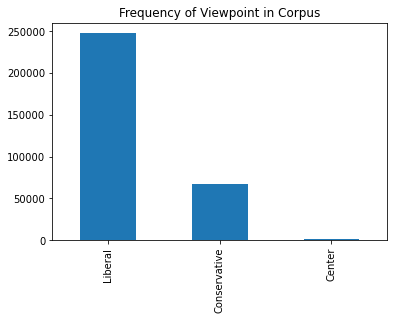

In [45]:
corpus['target'].value_counts().plot(kind='bar', title='Frequency of Viewpoint in Corpus');

There is quite an imbalance in viewpoints within the Princeton Corpus of Poltiical Emails. Liberal viewpoints are represented almost 4 times more than conservative viewpoints and over 100 times more than 'center' viewpoints. 

How are the number of campaigns and organzations represented within each viewpoint? 

In [46]:
corpus['date'] = pd.to_datetime(corpus['date'])
corpus['crawl_date'] = pd.to_datetime(corpus['crawl_date'])
corpus['target'] = corpus['target'].astype('category')

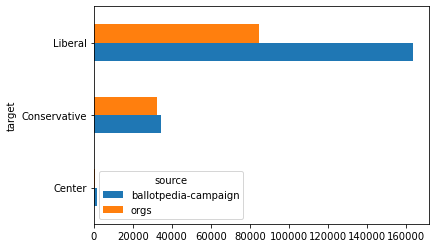

In [80]:
corpus.groupby('source').target.value_counts().unstack(0).plot.barh();

Within the liberal viewpoint more emails originate from campains than organziations. In the conservative viewpoint there is a balance between campains and organizations. 

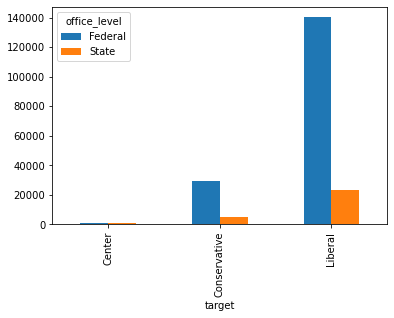

In [79]:
corpus.groupby('office_level').target.value_counts().unstack(0).plot.bar();

In [87]:
#Which elections for office sent the most email? 
corpus['office_sought'].value_counts()[:5]

President of the United States     8831
U.S. House New York District 18    7988
U.S. House Illinois District 3     6042
U.S. House Texas District 2        5935
U.S. House Oregon District 4       4905
Name: office_sought, dtype: int64

In [111]:
corpus['name'].loc[corpus['office_sought']=='President of the United States'].value_counts()[:5]

Donald Trump      2236
Joe Biden         1275
Michael Bennet     901
Pete Buttigieg     533
Steve Bullock      499
Name: name, dtype: int64

In [71]:
#create dataframe by viewpoint
liberal = corpus.loc[corpus['target']=='Liberal']
conservative = corpus.loc[corpus['target']=='Conservative']
center = corpus.loc[corpus['target']=='Center']

In [117]:
#number of candidates for president in the liberal viewpoint
len(liberal.loc[liberal['office_sought']=='President of the United States'].name.unique())

32

In [118]:
#number of candidates for president in the conservative viewpoint
len(conservative.loc[conservative['office_sought']=='President of the United States'].name.unique())

21

Most emails were sent from campaigns for President of the United States. In 2020 the Democratic Party's presidential primaries had the [largest field of presidential candidates since 1972](https://en.wikipedia.org/wiki/2020_Democratic_Party_presidential_primaries). Therefore, most emails in the corpus were from Presidential Campaigns, where most of the candidates contained liberal viewpoints. 

Who sent the most email overall? 

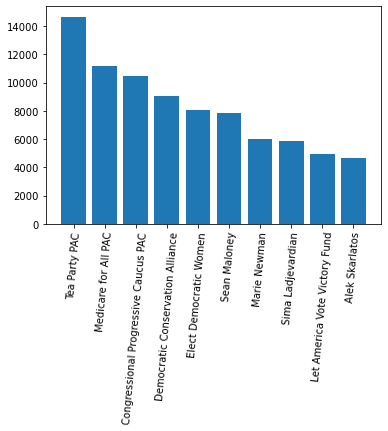

In [128]:
plt.bar(corpus['name'].value_counts().index[:10], corpus['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

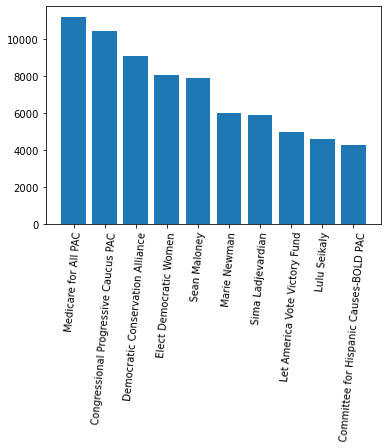

In [129]:
#liberal viewpoints most emails
plt.bar(liberal['name'].value_counts().index[:10], liberal['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

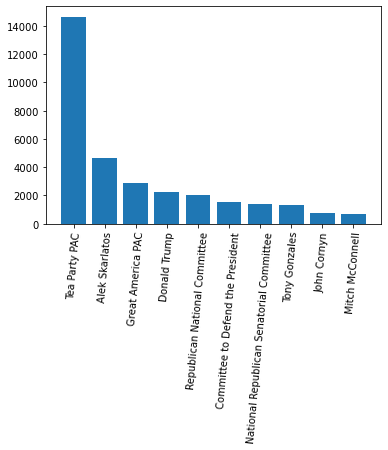

In [130]:
#conservative viewpoints most emails
plt.bar(conservative['name'].value_counts().index[:10], conservative['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

In [131]:
conservative['name'].value_counts(normalize=True)[:5]

Tea Party PAC                    0.219262
Alek Skarlatos                   0.070044
Great America PAC                0.043478
Donald Trump                     0.033466
Republican National Committee    0.029933
Name: name, dtype: float64

Emails from Tea Party PAC contitutes approximately 22% of all emails from the 'conservative' viewpoint.

In [174]:
corpus.loc[corpus['key']=='teapartypac']

,from_name,from_address,subject,body_text,name,office_sought,party_affiliation,office_level,district_type,final_website,crawl_date,source,state,type,subtype,date,hour,day,uid_email,uid_inbox,incumbent,target,key,text,length
175155,Trump-deadline@nrcc.org,news@libertybell.com,patriots needed before Trump takes the stage,Please DO NOT let President Trump and his alli...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-09-09,9,Wed,cbd529eedf2598b64f8dfe0704a1fabc,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,patriots needed before Trump takes the stage. ...,316501
175156,Trump-deadline@nrcc.org,news@libertybell.com,Your opt-in link will expire in less than 12 h...,Not interested? Unsubscribe Here\nBy joining t...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-09-09,11,Wed,37c6f814e074a849fed208a10b9cf9b3,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,Your opt-in link will expire in less than 12 h...,316501
175157,Marco Rubio,marcorubio@thedailygrind.news,The Republican National Convention polls are i...,"Fellow Conservative, The Republican National C...",Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-08-26,17,Wed,a5293016b938f406d3704e773707b269,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,The Republican National Convention polls are i...,316501
175158,"Nikki Haley"" <senate@@TheDailyGrind.news>",NaN,The future of the America First agenda is in Y...,Republican Senate candidates in battleground s...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-06-30,21,Tue,23b2e5f31b0a2d1e7b59ea9d6b4c380c,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,The future of the America First agenda is in Y...,316501
175159,Ric Grennell,ric@thedailygrind.news,Remember me?,&zw wnj;\nMcSally for Senate\nHi Fellow Conser...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-08-09,7,Sun,4efb84c6a7c999ec74489e5a97b15264,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,Remember me?. &zw wnj;\nMcSally for Senate\nHi...,316501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189800,Tim Scott,timscott@thedailygrind.news,token,This is one of the hardest emails I have ever ...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-06-23,11,Tue,be763364f88dfef98d99c41cc8c98545,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,token. This is one of the hardest emails I hav...,316501
189801,Tim Scott,timscott@thedailygrind.news,Did you hear what Bernie said?,"Last night at the Democrat convention, Sociali...",Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-08-18,17,Tue,8f4b1d29450bb604349ce29745311d8f,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,Did you hear what Bernie said?. Last night at ...,316501
189802,Tim Scott,timscott@thedailygrind.news,Defending the Second Amendment,The election is still more than two months awa...,Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-08-13,16,Thu,f73531a28edf74e4483eb6ab676a29d8,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,Defending the Second Amendment. The election i...,316501
189803,Tim Scott,timscott@thedailygrind.news,"Less Government, More Freedom","As a proud conservative, I have always advocat...",Tea Party PAC,NaN,NaN,NaN,NaN,https://teapartypac.org/,2019-12-02,orgs,NaN,Super PAC,NaN,2020-08-03,18,Mon,b6ad4a6d901307ce6298314b4c9713b3,a29669159cad2526ebfc10718b6b3eaf,NaN,Conservative,teapartypac,"Less Government, More Freedom. As a proud cons...",316501


# Data Cleaning

In [150]:
corpus['text'] = corpus['subject'] +". "+ corpus['body_text']

In [179]:
test_text = corpus['text'][175158]
test_text

'The future of the America First agenda is in YOUR hands. Republican Senate candidates in battleground states are counting on important resources from conservatives like YOU. That means Republicans must reach our fundraising goals before the end of this quarter. Donate to defend the Senate Majority and President Trump before midnight to be 5x matched >>\nFellow Conservative,\nPresident Trump and his allies in the Senate need your help. Democrats are now campaigning to:\n* DISMANTLE and DEFUND local police departments and law enforcement,\n* Look the other way to APPEASE CHINA, instead of holding its communist regime accountable for constant efforts to gain international influence,\n* SUPPORT socialist ideas and policies that undermine America’s founding principles and would devastate our economy.\nIt’s unreal to see such radical policies becoming a part of Democrats’ mainstream platform. That’s why it’s more important than ever for Republicans to rally together in 2020! Chip in now to 

In [202]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

In [194]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [198]:
corpus['tokens'] = corpus['text'].astype(str)

In [199]:
corpus['tokens'] = corpus['tokens'].apply(tokenizer.tokenize)

In [203]:
nltk_stopwords = stopwords.words('english')

corpus['tokens'] = corpus['tokens'].apply(lambda x: [word for word in x if word not in nltk_stopwords])